### Description of the model

In the model with two rings coupled, an extra term representing the feedforward connection from one ring to another, is added to the synaptic current.

$I_{lr}(k,t) = \sum_{q \in \text{ remote ring}} W_{qk}R_{q}(t - D_{lr})$

The kernel $W_{rqk}$ has a rectangular shape, and it assumes a positive amplitude $A_{lr}$ within the range $k-\sigma_{lr} \leq q \leq k+\sigma_{lr}$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numba import *
from tqdm import tqdm

#### Import core model functions

In [2]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/nicole_model")

In [3]:
from src.integration import config_simulation
from src.model import create_ring, dRdt, set_external_ring_coupling
from src.utils import batch

In [4]:
def simulate_two_rings(
    state=["SU", "SU"],
    integration="euler",
    N=100,
    trials=1,
    h=0.01,
    tsim=10.0,
    trans=5.5,
    delay=10,
    delay_lr=20,
    decim=10,
    s_pos=0,
    s_on=0,
    s_off=0,
    A_stim=0,
    sig_stim=1,
    batch_size=1,
    verbose=False,
):
    """
    Simulates the activity of two coupled neural rings using a differential equation model.

    Parameters
    ----------
    state : list or array-like, optional
        Initial state of the two neural rings. Each element of the list is a string that represents
        the type of the neural units in the corresponding ring. Default is ['SU', 'SU'].
    integration : {'euler', 'rk4'}, optional
        Integration method for the differential equations. Default is 'euler'.
    N : int, optional
        Number of neural units in each ring. Default is 100.
    trials : int, optional
        Number of independent trials to simulate. Default is 1.
    h : float, optional
        Integration step size. Default is 0.01.
    tsim : float, optional
        Total simulation time, in seconds. Default is 10.0.
    trans : float, optional
        Transient period to discard, in seconds. Default is 5.5.
    delay : int, optional
        Delay between the external input and the internal dynamics, in time steps. Default is 10.
    delay_lr : int, optional
        Delay between the two neural rings, in time steps. Default is 20.
    decim : int or None, optional
        Decimation factor to apply to the simulated data. If None, no decimation is applied.
        Default is 10.
    s_pos : int or float, optional
        Position of the stimulus on the ring, in neural units. If 0, no stimulus is applied.
        Default is 0.
    s_on : array-like or float, optional
        Onset time of the stimulus, in seconds. If float, the same onset time is used for all trials.
        If array-like, it should have length equal to the number of trials. Default is 0.
    s_off : array-like or float, optional
        Offset time of the stimulus, in seconds. If float, the same offset time is used for all trials.
        If array-like, it should have length equal to the number of trials. Default is 0.
    A_stim : float, optional
        Amplitude of the stimulus. Default is 0.
    sig_stim : float, optional
        Standard deviation of the additive noise in the stimulus. Default is 1.
    batch_size : int, optional
        Number of trials to simulate in each batch. Default is 1.
    verbose : bool, optional
        Whether to display a progress bar during the simulation. Default is False.

    Returns
    -------
    R1 : xarray DataArray
        Array containing the activity of the first neural ring. It has dimensions (trials, times, nodes),
        where 'trials' is the number of independent trials simulated, 'times' is the time axis of the simulation,
        and 'nodes' is the number of neural units in the ring.
    R2 : xarray DataArray
        Array containing the activity of the second neural ring. It has dimensions (trials,
    """
    assert isinstance(state, (list, np.array, tuple))

    fint, steps, times = config_simulation(integration, tsim, h)

    s_on = [int(onset / h) for onset in s_on]
    s_off = [int(offset / h) for offset in s_off]

    # Create first ring
    J1, Iext1, Istim1, theta1, R1 = create_ring(
        state=state[0],
        N=N,
        trials=trials,
        steps=steps,
        s_pos=s_pos,
        s_on=s_on,
        s_off=s_off,
        A_stim=A_stim,
        sig_stim=sig_stim,
    )
    # Create second ring
    J2, Iext2, Istim2, theta2, R2 = create_ring(
        state=state[1],
        N=N,
        trials=trials,
        steps=steps,
        s_pos=s_pos,
        s_on=s_on,
        s_off=s_off,
        A_stim=0,
        sig_stim=sig_stim,
    )

    # Define feedforward coupling
    J12 = set_external_ring_coupling(N, 15 / N, 3)
    # Define feedback coupling
    J21 = set_external_ring_coupling(N, 23 / N, 6)

    # Index of each trial
    trials_idx = np.arange(0, trials, dtype=int)

    def _simulate_batch(i_):
        R1[i_, : delay + 1] = np.random.uniform(0, 0.1, size=R1[i_, : delay + 1].shape)
        R2[i_, : delay + 1] = np.random.uniform(0, 0.1, size=R2[i_, : delay + 1].shape)
        # Solve the ODE using RK4
        for t in range(delay, steps):
            R1[i_, t, :] = fint(
                dRdt,
                R1[i_, t - 1, :],
                times[t],
                h,
                Iext1[i_, t],
                Istim1[t],
                R1[i_, t - delay, :] @ J1 + R2[i_, t - delay_lr, :] @ J21.T,
            )
            R2[i_, t, :] = fint(
                dRdt,
                R2[i_, t - 1, :],
                times[t],
                h,
                Iext2[i_, t],
                0.0,
                R2[i_, t - delay, :] @ J2 + R1[i_, t - delay_lr, :] @ J12,
            )

    # Simulate trial batches
    nbatches = int(trials / batch_size)
    pbar = batch(trials_idx, n=batch_size)

    if verbose:
        pbar = tqdm(pbar)

    n = 1
    for indexes in pbar:
        _simulate_batch(indexes)
        if verbose:
            pbar.set_description(f"Simulating trials batch {n}/{nbatches}")
            n = n + 1

    # Apply decimation
    if isinstance(decim, int):
        times = times[::decim]
        R1 = R1[:, ::decim, :]
        R2 = R2[:, ::decim, :]

    trans = int(trans / (decim * h))
    # Discard transient
    R1 = R1[:, trans:, :]
    R2 = R2[:, trans:, :]

    R1 = xr.DataArray(
        R1,
        dims=("trials", "times", "nodes"),
        coords=(trials_idx, times[:-trans], theta1),
    )

    R2 = xr.DataArray(
        R2,
        dims=("trials", "times", "nodes"),
        coords=(trials_idx, times[:-trans], theta2),
    )

    # Discard transient
    R1 = R1.sel(times=slice(trans))
    R2 = R2.sel(times=slice(trans))

    return R1, R2

##### Attention ON

In [5]:
R1, R2 = simulate_two_rings(
    state=["SU", "SB"],
    integration="rk4",
    tsim=61 + 40,
    trans=40,
    trials=50,
    batch_size=25,
    verbose=True,
    decim=10,
    s_pos=[50, 10],
    s_on=[11 + 40, 46 + 40],
    s_off=[31 + 40, 61 + 40],
    A_stim=2.0,
    sig_stim=8,
)

Simulating trials batch 2/2: : 2it [00:04,  2.07s/it]


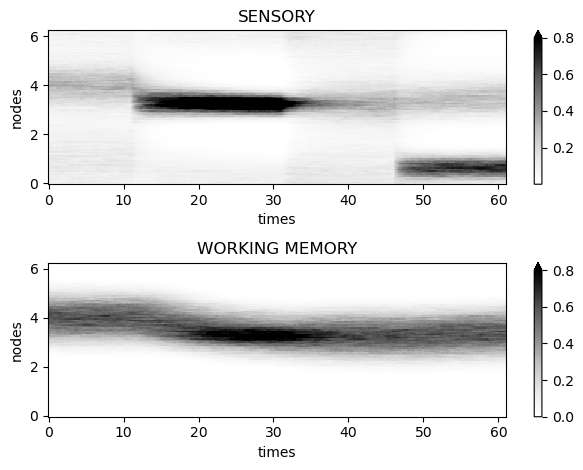

In [6]:
plt.subplot(211)
R1.sel(trials=20).plot(x="times", cmap="Greys", vmax=0.8)
plt.title("SENSORY")
plt.subplot(212)
R2.sel(trials=20).plot(x="times", cmap="Greys", vmax=0.8)
plt.title("WORKING MEMORY")
plt.tight_layout()

##### Attention OFF

In [7]:
R1, R2 = simulate_two_rings(
    state=["SU", "SU"],
    integration="rk4",
    tsim=61 + 40,
    trans=40,
    trials=50,
    batch_size=25,
    verbose=True,
    decim=10,
    s_pos=[50, 10],
    s_on=[11 + 40, 46 + 40],
    s_off=[31 + 40, 61 + 40],
    A_stim=2.0,
    sig_stim=8,
)

Simulating trials batch 2/2: : 2it [00:04,  2.01s/it]


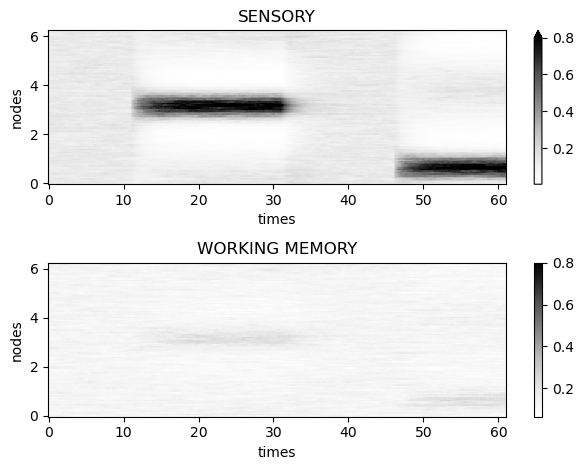

In [8]:
plt.subplot(211)
R1.sel(trials=10).plot(x="times", cmap="Greys", vmax=0.8)
plt.title("SENSORY")
plt.subplot(212)
R2.sel(trials=10).plot(x="times", cmap="Greys", vmax=0.8)
plt.title("WORKING MEMORY")
plt.tight_layout()

#### IPP analysis

In [9]:
# Stimulus positions
Spos = np.arange(0, 100, 10, dtype=int)

In [10]:
RSU = []

R1, R2 = [], []

for spos in Spos:

    R1_temp, R2_temp = simulate_two_rings(
        state=["SU", "SB"],
        integration="rk4",
        tsim=61 + 40,
        trans=40,
        trials=300,
        batch_size=100,
        verbose=True,
        decim=10,
        s_pos=[50, spos],
        s_on=[11 + 40, 46 + 40],
        s_off=[31 + 40, 61 + 40],
        A_stim=2.0,
        sig_stim=8,
    )

    R1 += [R1_temp]
    R2 += [R2_temp]

R1 = xr.concat(R1, "trials").assign_coords({"trials": range(len(Spos) * 300)})
R2 = xr.concat(R2, "trials").assign_coords({"trials": range(len(Spos) * 300)})

Simulating trials batch 3/3: : 3it [01:01, 20.58s/it]
Simulating trials batch 3/3: : 3it [01:19, 26.36s/it]
Simulating trials batch 3/3: : 3it [01:11, 23.99s/it]
Simulating trials batch 3/3: : 3it [01:17, 25.99s/it]
Simulating trials batch 3/3: : 3it [01:08, 22.99s/it]
Simulating trials batch 3/3: : 3it [01:03, 21.04s/it]
Simulating trials batch 3/3: : 3it [01:02, 20.69s/it]
Simulating trials batch 3/3: : 3it [01:23, 27.89s/it]
Simulating trials batch 3/3: : 3it [01:24, 28.01s/it]
Simulating trials batch 3/3: : 3it [01:04, 21.63s/it]


In [11]:
from src.infodyn.conn_pid import conn_pid

In [12]:
stim = np.repeat(Spos, 300)

In [13]:
nodes1 = [f"{i}_1" for i in range(100)]
nodes2 = [f"{i}_2" for i in range(100)]

In [14]:
R1 = R1.assign_coords({"nodes": nodes1})
R2 = R2.assign_coords({"nodes": nodes2})

In [15]:
R = xr.concat((R1, R2), "nodes")

In [16]:
pairs = np.stack((range(100), range(100, 200)), 1)

In [17]:
def fix_frites(func):  # noqa
    def _fix(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            return 0
    return _fix

In [18]:
conn_pid = fix_frites(conn_pid)

In [19]:
mi_node, unique, infotot, redundancy, synergy = conn_pid(
    R.transpose("trials", "nodes", "times"),
    stim,
    roi="nodes",
    times="times",
    mi_type="cd",
    dt=10,
    verbose=True, pairs = pairs,
    directed=False
)

Defining links (n_roi=200; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute PID on 100 connectivity pairs
    Apply the Gaussian Copula Rank Normalization
    Estimating PID in the network
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████| Estimating unique information and synergy : 500/500 [07:29<00:00,    1.11it/s]


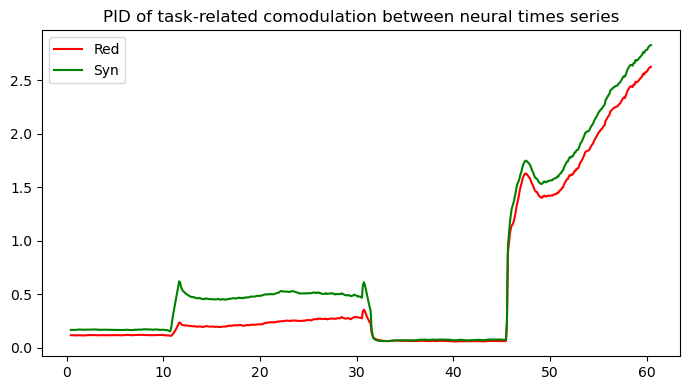

In [20]:
# Plotting
plt.figure(figsize=(7, 4))

times = redundancy.times.data
"""
plt.plot(
    times,
    infotot.mean("roi").squeeze(),
    color="blue",
    linestyle="--",
    label=r"$I_{TOT}$",
)"""
plt.plot(times, redundancy.mean("roi").squeeze(), color="red", label="Red")
plt.plot(times, synergy.mean("roi").squeeze(), color="green", label="Syn")
plt.legend()

plt.title("PID of task-related comodulation between neural times series")

plt.tight_layout()
plt.show()

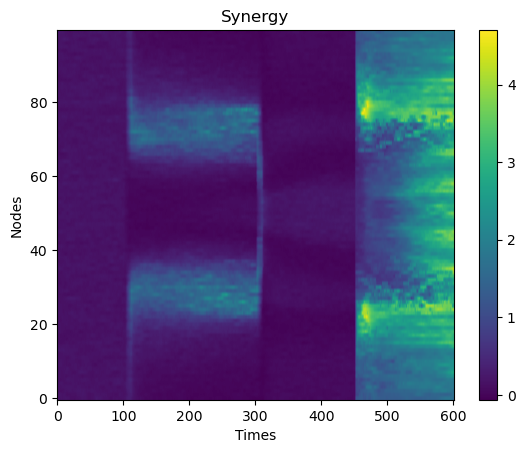

In [21]:
plt.imshow(
    synergy,
    aspect="auto",
    origin="lower",
)
plt.title("Synergy")
plt.xlabel("Times")
plt.ylabel("Nodes")
plt.colorbar()

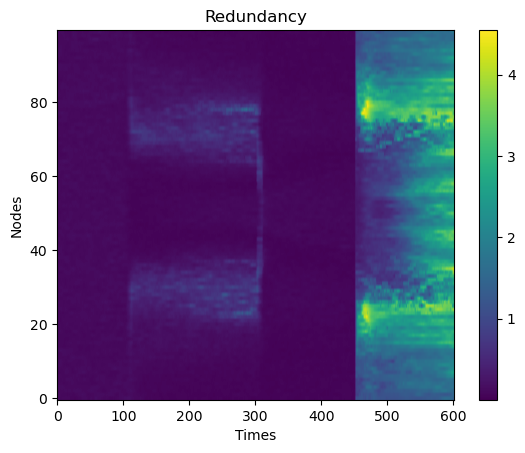

In [22]:
plt.imshow(
    redundancy,
    aspect="auto",
    origin="lower",
)
plt.title("Redundancy")
plt.xlabel("Times")
plt.ylabel("Nodes")
plt.colorbar()

Text(0.5, 0, 'Nodes')

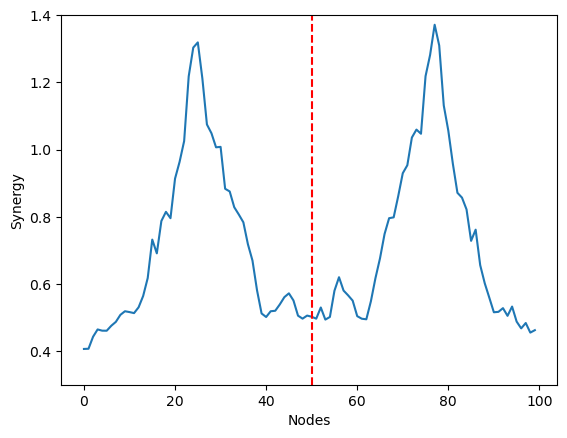

In [27]:
plt.plot(synergy.mean("times"))
plt.vlines(50, 0.3, 1.4, "r", "--")
plt.ylim(0.3, 1.4)
plt.ylabel("Synergy")
plt.xlabel("Nodes")